In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

matplotlib.style.use('ggplot')

path = Path("raw_data")

## Train sequences

In [3]:
def load_sequences(fasta_file):
    sequences = {}
    current_id = None
    with open(fasta_file, 'rt') as file:
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                # Extract the protein identifier from the line
                identifier = line[1:].split()[0]
                current_id = identifier
                sequences[current_id] = ''
            else:
                sequences[current_id] += line

    # Print number of protein sequences
    print(str(len(sequences)) + ' ids loaded.')
    return sequences


train_file = path/"Train/train_sequences.fasta"
train_sequences = load_sequences(train_file)

142246 ids loaded.


In [4]:
train_sequences_df = pd.DataFrame.from_dict(train_sequences, orient='index', columns=['sequence'])
train_sequences_df.head()

,sequence
P20536,MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...
O73864,MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...
O95231,MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...
A0A0B4J1F4,MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...
P54366,MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...


## Labels

In [5]:
train_labels = pd.read_csv(path/'Train/train_terms.tsv', sep='\t')
train_labels.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


Let's take a random EntryID and check if it is in train_sequences. Let's take A0A009IHW8 for example.

In [6]:
entry_ID = "A0A009IHW8"

if entry_ID in train_sequences_df.index:
    print(f"{entry_ID} is in the training set. The sequence is:")
    print(train_sequences_df.loc[entry_ID]['sequence'])
    print("The corresponding GO terms are:")
    print(train_labels[train_labels['EntryID'] == entry_ID]['term'].values)
    print(f"There are {len(train_labels[train_labels['EntryID'] == entry_ID])} GO terms associated with {entry_ID}.")

A0A009IHW8 is in the training set. The sequence is:
MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENARIQSKLSDLQKKKIDIDNKLLKEKQNLIKEEILERKKLEVLTKKQQKDEIEHQKKLKREIDAIKASTQYITDVSISSYNNTIPETEPEYDLFISHASEDKEDFVRPLAETLQQLGVNVWYDEFTLKVGDSLRQKIDSGLRNSKYGTVVLSTDFIKKDWTNYELDGLVAREMNGHKMILPIWHKITKNDVLDYSPNLADKVALNTSVNSIEEIAHQLADVILNR
The corresponding GO terms are:
['GO:0008152' 'GO:0034655' 'GO:0072523' 'GO:0044270' 'GO:0006753'
 'GO:1901292' 'GO:0044237' 'GO:1901360' 'GO:0008150' 'GO:1901564'
 'GO:1901565' 'GO:0009117' 'GO:0006139' 'GO:0044281' 'GO:0046496'
 'GO:0019362' 'GO:0046483' 'GO:0055086' 'GO:0044248' 'GO:0019439'
 'GO:0019637' 'GO:0006807' 'GO:0019677' 'GO:1901361' 'GO:0006163'
 'GO:0046700' 'GO:0009987' 'GO:0006725' 'GO:0006796' 'GO:0034641'
 'GO:0072521' 'GO:0071704' 'GO:0019364' 'GO:1901575' 'GO:0072526'
 'GO:0046434' 'GO:0009166' 'GO:0072524' 'GO:0006195' 'GO:0009056'
 'GO:0044238' 'GO:0006793' 'GO:0019674' 'GO:0003674' 'GO:0003953'
 'GO:0016787' 'GO:0016799' 'GO:0016798' 'GO:0003824'

In [7]:
# Find the total number of unique GO terms in the training set
print(f"Total number of unique GO terms is {len(train_labels['term'].unique())}.")

# Find the number of unique GO terms by aspect
aspects = train_labels['aspect'].unique()
for aspect in aspects:
    print(f"Number of unique GO terms in the {aspect} aspect is {len(train_labels[train_labels['aspect'] == aspect]['term'].unique())}.")

Total number of unique GO terms is 31466.
Number of unique GO terms in the BPO aspect is 21285.
Number of unique GO terms in the CCO aspect is 2957.
Number of unique GO terms in the MFO aspect is 7224.


For completion, this is what the abbreviation of the labels mean:
- BPO: Biological Process Ontology
- CCO: Cellular Component Ontology
- MFO: Molecular Function Ontology

### GO terms label selection

We will select the GO terms that we will use to train a model. This is necessary because we are limited to a total number of 1500 GO terms by the rules of the competition. We will start with a simple selection procedure that selects the top 500 most frequent GO terms in each of the three ontologies. We will then try to improve this selection by using a more sophisticated method later.

In [8]:
# This is how some other guy on kaggle did it
"""
V = {}
V['BPO'] = 1100
V['CCO'] = 300
V['MFO'] = 450

selected_terms = []
for aspect in ['BPO', 'CCO', 'MFO']:
    selection = terms.loc[(terms.aspect == aspect)]
    selection = selection.nlargest(V[aspect], columns='frequency', keep='first')
    selected_terms += selection.term.to_list()
selected_terms = set(selected_terms)
"""
# Good idea is to balance out the GO terms by aspect
# Then he assigned a vector to each GO term:
"""
def assign_labels(annotations, selected_terms=selected_terms):
    
    intersection = selected_terms.intersection(annotations)
    labels = np.isin(np.array(list(selected_terms)), np.array(list(intersection))) #+ random.rand(1)*0.000001 - random.rand(1)*0.000001 
    
    return list(labels.astype('int'))

annotations = train_terms.groupby('EntryID')['term'].apply(set)
labels = annotations.progress_apply(assign_labels)

labels.head()
"""

"\ndef assign_labels(annotations, selected_terms=selected_terms):\n    \n    intersection = selected_terms.intersection(annotations)\n    labels = np.isin(np.array(list(selected_terms)), np.array(list(intersection))) #+ random.rand(1)*0.000001 - random.rand(1)*0.000001 \n    \n    return list(labels.astype('int'))\n\nannotations = train_terms.groupby('EntryID')['term'].apply(set)\nlabels = annotations.progress_apply(assign_labels)\n\nlabels.head()\n"

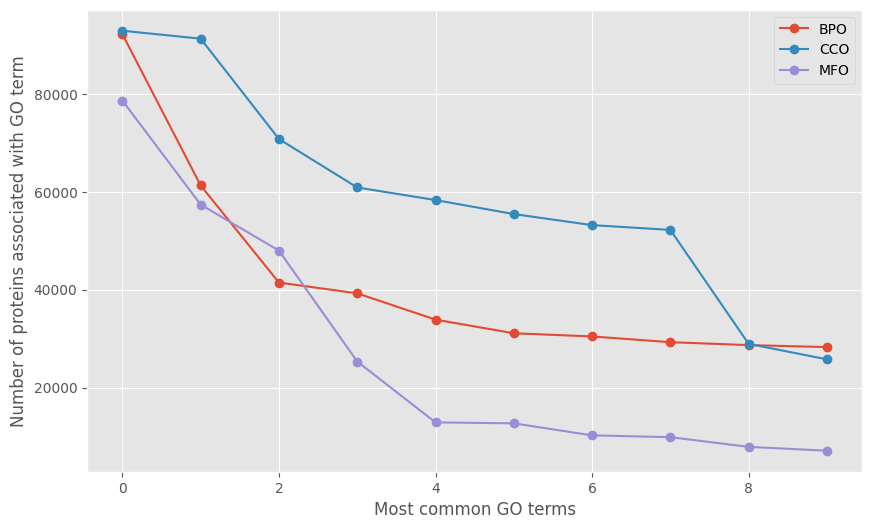

In [9]:
# Group the GO terms by aspect and then by GO term
grouped_terms = train_labels.groupby(['aspect', 'term']).count()
# Sort the grouped terms by the number of proteins associated with each GO term, in descending order,
# group within each aspect
grouped_terms = grouped_terms.sort_values(by='EntryID', ascending=False)
bpo_500 = grouped_terms.loc[grouped_terms.index.get_level_values('aspect') == 'BPO', "EntryID"][:500].index.get_level_values('term').values
cco_500 = grouped_terms.loc[grouped_terms.index.get_level_values('aspect') == 'CCO', "EntryID"][:500].index.get_level_values('term').values
mfo_500 = grouped_terms.loc[grouped_terms.index.get_level_values('aspect') == 'MFO', "EntryID"][:500].index.get_level_values('term').values

selected_terms = set(np.concatenate([bpo_500, cco_500, mfo_500]))
selected_terms = list(selected_terms)
num_of_labels = len(selected_terms)

# Plot the number of proteins associated with each GO term, grouped by aspect
grouped_terms = grouped_terms.reset_index()
fig, ax = plt.subplots(figsize=(10, 6))

n_top_terms = 10
for aspect in aspects:
    aspect_df = grouped_terms[grouped_terms['aspect'] == aspect]
    ax.plot(np.arange(n_top_terms), aspect_df['EntryID'][:n_top_terms], label=aspect, marker='o')
ax.set_xlabel('Most common GO terms')
ax.set_ylabel('Number of proteins associated with GO term')
ax.legend()
plt.show()

Let's create a vector for each protein in the train set. We have a 1500 classes classification problem so for each protein we will have a 1500 long vector with 1s and 0s. 1s will be in the positions of the GO terms that the protein has and 0s in the positions of the GO terms that the protein doesn't have.

In [10]:
# Most of the following code is adapted from
# https://www.kaggle.com/code/gusthema/cafa-5-protein-function-with-tensorflow

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_labels_updated = train_labels.loc[train_labels['term'].isin(selected_terms)]
series_train_protein_ids = pd.Series(train_sequences_df.index)

train_size = train_sequences_df.shape[0] # len(X)
train_vector_labels = np.zeros((train_size, num_of_labels))

for i in range(num_of_labels):
    print(f"Processing label {i+1} of {num_of_labels}", end='\r')
    # For each label, fetch the corresponding train_labels data
    n_train_terms = train_labels_updated[train_labels_updated['term'] == selected_terms[i]]
    
    # Fetch all the unique EntryIDs for the current label
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0
    train_vector_labels[:, i] = series_train_protein_ids.isin(label_related_proteins).astype(int)

print("") # Get to the next line
labels_df = pd.DataFrame(train_vector_labels, columns=selected_terms, index=train_sequences_df.index)
print(labels_df.shape)

Processing label 1500 of 1500
(142246, 1500)


In [11]:
labels_df.head()

,GO:1903561,GO:0004659,GO:0030334,GO:0000793,GO:0061733,GO:0048666,GO:0052689,GO:0061061,GO:0022402,GO:0016247,...,GO:0031974,GO:0005912,GO:0005575,GO:0010038,GO:0003006,GO:0009887,GO:0009059,GO:0008094,GO:0005930,GO:0070469
P20536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
O73864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
O95231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A0B4J1F4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P54366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


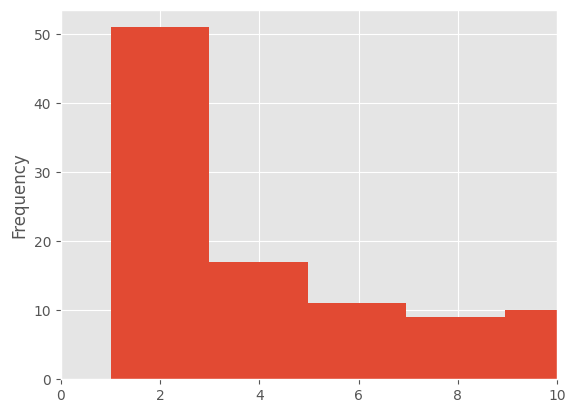

In [12]:
# Check how many proteins have no labels
ax = labels_df.sum(axis=1).value_counts().plot(kind='hist', bins=5000)
ax.set_xlim(0, 10)
plt.show()

# As we can see there are no proteins with no labels - great success (Borat voice)!

Consider $Y_i$ to be a set of labels for the $i^{th}$ data sample. The extent to which a dataset is multi-label can be captured in two statistics:
- Label cardinality, or the average number of labels per example in the set: $\frac{1}{N} \sum_{i=1}^N |Y_i|$
- Label density is the number of labels per sample divided by the total number of labels, averaged over the samples: $\frac{1}{N} \sum_{i=1}^N \frac{|Y_i|}{|L|}$, where $L = \bigcup_{i=1}^N Y_i$ is the set of all labels in the dataset.

In [13]:
# Let's find the label cardinality
print(f"The label cardinality of the training set is {labels_df.sum(axis=1).mean():.4f}.")
# Let's find the label density
print(f"The label density of the training set is {labels_df.sum(axis=1).sum() / (labels_df.shape[1] * labels_df.shape[0]):.4f}.")

The label cardinality of the training set is 29.1235.
The label density of the training set is 0.0194.


### Save the selected labels

In [65]:
import pyarrow.feather as feather

# Save the labels to a feather file
feather.write_feather(labels_df, 'train-ready_data/protein_labels.feather')

# Save the sequences to a feather file
feather.write_feather(train_sequences_df, 'train-ready_data/protein_sequences.feather')